In [1]:
#Import Dependencies
import pandas as pd
import numpy as np
import tensorflow

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler , StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [2]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /Users/igorpyanin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages (0.0)


In [3]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [5]:
file2 = "data_cleaning/Output/cleaned_data.csv"
df2 = pd.read_csv(file2)
df2.head()

,zipcode,room_type,accommodates,bedrooms,bathrooms,beds,minimum_nights,number_of_reviews,price,price_bin
0,94117,Entire home/apt,3,1.0,1.0,2.0,1,240,170.0,bin 144-180
1,94110,Entire home/apt,5,2.0,1.0,3.0,30,111,235.0,bin 216-252
2,94117,Private room,2,1.0,4.0,1.0,32,19,65.0,bin 36-72
3,94117,Private room,2,1.0,4.0,1.0,32,8,65.0,bin 36-72
4,94110,Private room,3,1.0,1.0,1.0,1,736,139.0,bin 108-144


### Compare 10 and 14 bins for price

#### 10 bins

In [6]:
file = "data_cleaning/Output/cleaned_data_bin_50.csv"
df = pd.read_csv(file)
price_bins = df.sort_values('price').drop_duplicates('price_bin')['price_bin'].values
bin_cnt = df[['price_bin']].groupby('price_bin').size()
bin_counts = [bin_cnt.loc[bin_name] for bin_name in price_bins]

In [7]:
price_bins

array(['bin 0-50', 'bin 50-100', 'bin 100-150', 'bin 150-200',
       'bin 200-250', 'bin 250-300', 'bin 300-350', 'bin 350-400',
       'bin 400-450', 'bin 450-500'], dtype=object)

In [8]:
bin_counts

[398, 1887, 1906, 1335, 798, 534, 279, 200, 105, 63]

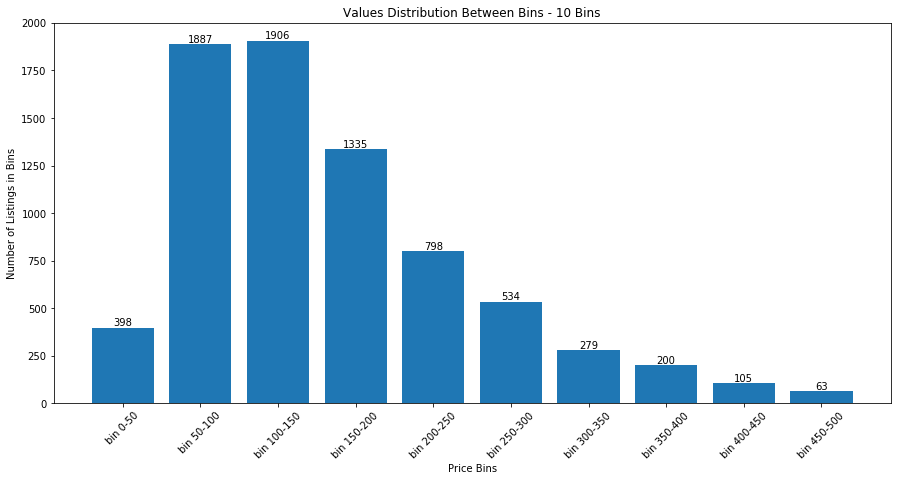

In [84]:
plt.figure(figsize=(15, 7))
plt.bar(x=price_bins, height=bin_counts)
plt.xticks(rotation=45)
for index, value in enumerate(price_bins):
    plt.text(value, bin_counts[index], str(bin_counts[index]),ha='center', va='bottom')
    
#Labeling lims
plt.ylabel("Number of Listings in Bins")
plt.xlabel("Price Bins")
#Adding a title
plt.title("Values Distribution Between Bins - 10 Bins")

plt.savefig("data_cleaning/Graphs/Val_distribution_10b.png")

#### 14 bins

In [17]:

price_bins2 = df2.sort_values('price').drop_duplicates('price_bin')['price_bin'].values
bin_cnt2 = df2[['price_bin']].groupby('price_bin').size()
bin_counts2 = [bin_cnt2.loc[bin_name] for bin_name in price_bins2]

In [11]:
price_bins2

array(['bin 0-36', 'bin 36-72', 'bin 72-108', 'bin 108-144',
       'bin 144-180', 'bin 180-216', 'bin 216-252', 'bin 252-288',
       'bin 288-324', 'bin 324-360', 'bin 360-396', 'bin 396-432',
       'bin 432-468', 'bin 468-504'], dtype=object)

In [18]:
bin_counts2

[87, 914, 1410, 1331, 1143, 792, 653, 274, 320, 236, 87, 130, 75, 53]

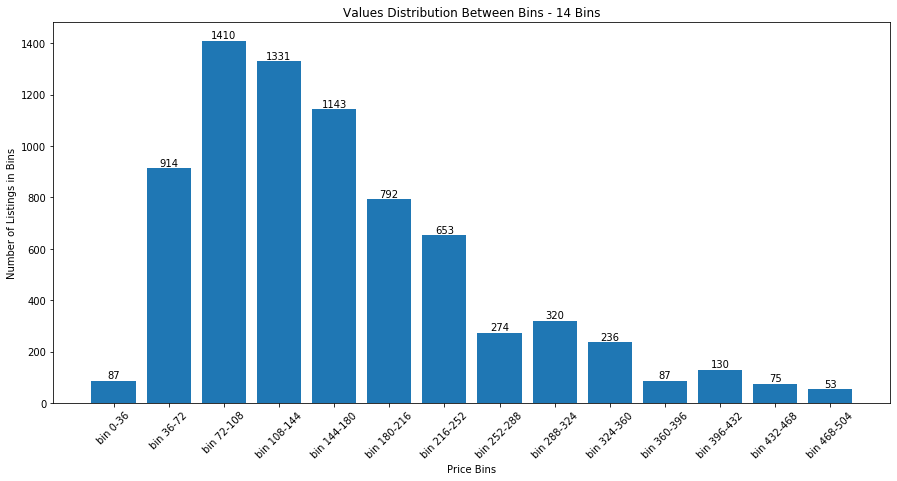

In [83]:
plt.figure(figsize=(15, 7))
plt.bar(x=price_bins2, height=bin_counts2)
plt.xticks(rotation=45)
for index, value in enumerate(price_bins2):
    plt.text(value, bin_counts2[index], str(bin_counts2[index]),ha='center', va='bottom')
    
#Labeling lims
plt.ylabel("Number of Listings in Bins")
plt.xlabel("Price Bins")
#Adding a title
plt.title("Values Distribution Between Bins - 14 Bins")
plt.savefig("data_cleaning/Graphs/Val_distribution_14b.png")


If we split prices into 14 bins we have more bins with small amount of data.
It can be good idea to make even less than 10 bins. 
Here are couple of options:
<li>  0-50, 50-100, 100-150, 150-200, 200-250, 250-300, 300-350, 350-400, 400-500
<li>  0-50, 50-100, 100-150, 150-200, 200-250, 250-300, 300-400, 400-500


### Feature values distribution

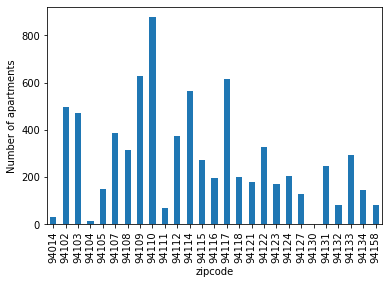

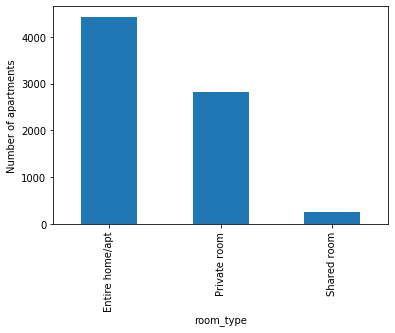

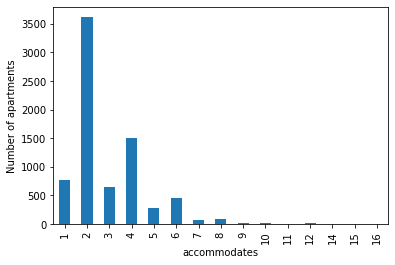

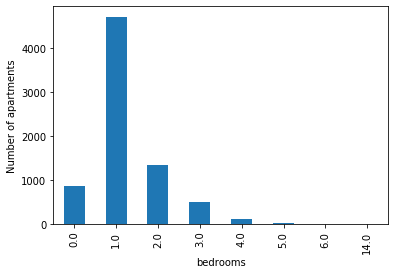

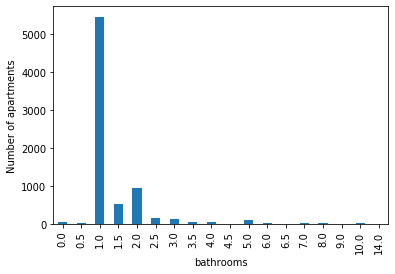

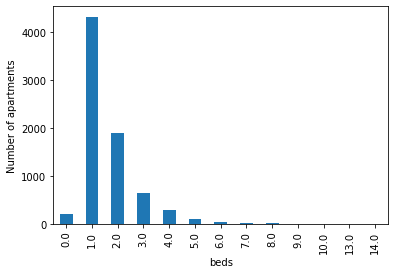

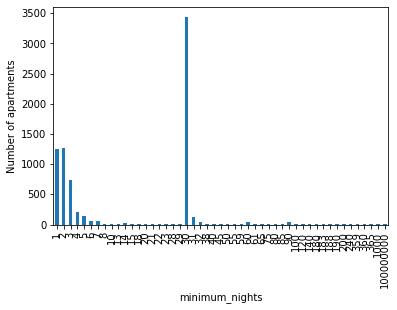

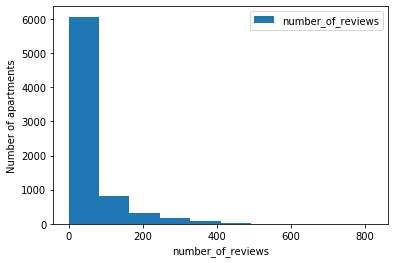

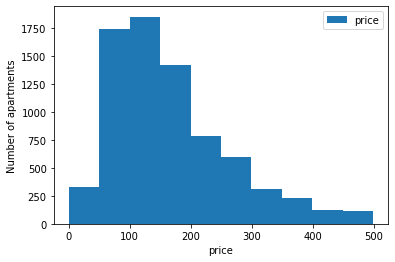

In [101]:
for column in df.columns:
    if column != 'price_bin':
        if column in ('number_of_reviews', 'price'):
            df[[column]].plot(kind='hist')
            plt.xlabel(column)

        else:
            df[[column]].groupby(column).size().plot(kind='bar')

        plt.ylabel('Number of apartments')
        plt.savefig("data_cleaning/Graphs/"+column+'.png')
        plt.show()



  ### Price versus feature scatter plot

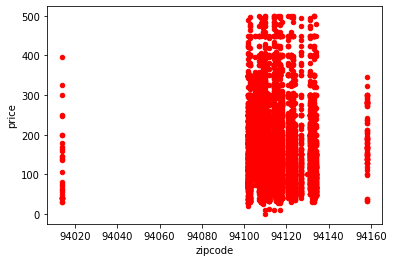

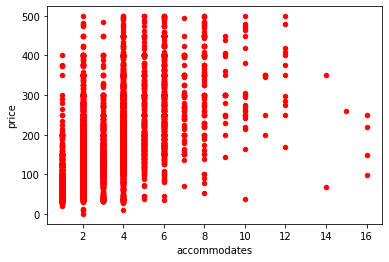

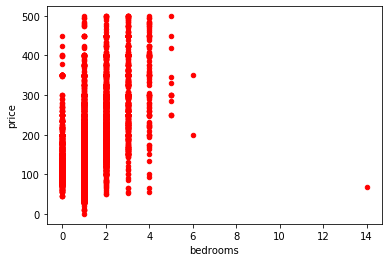

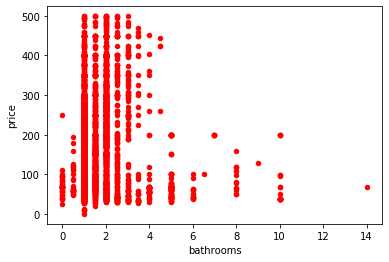

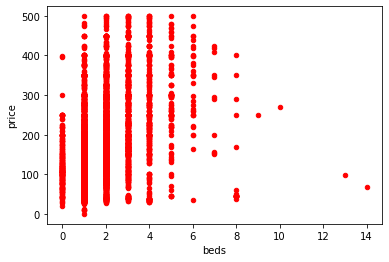

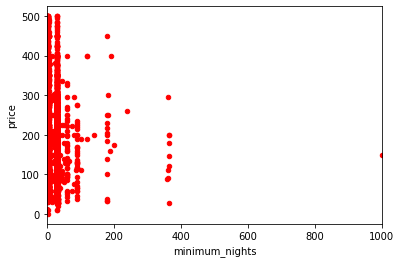

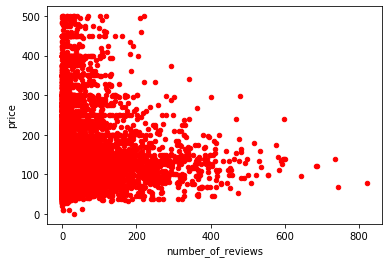

In [21]:
for column in df.columns:
    if column not in ('price_bin', 'price'):
        if column != 'room_type': 
            df[['price', column]].plot(x=column, y='price', kind='scatter', color='red')
            if column == 'minimum_nights':
                plt.xlim((0, 1000))
            plt.show()

### Mean price versus feature 

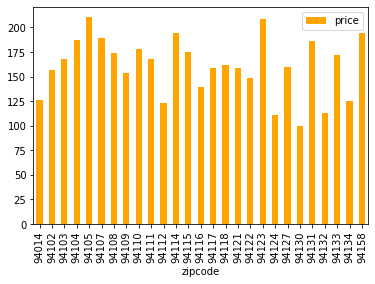

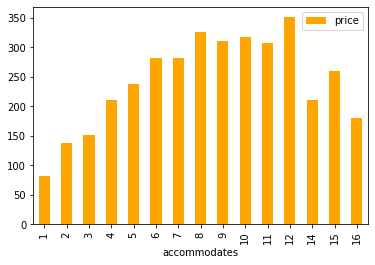

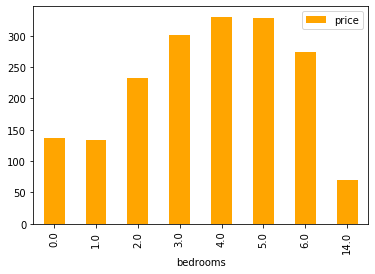

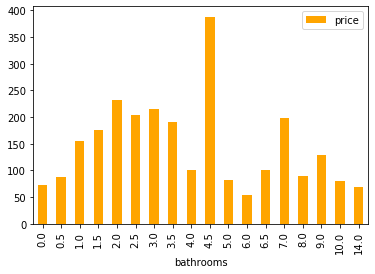

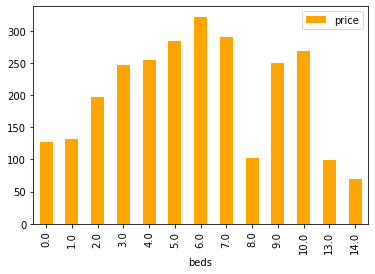

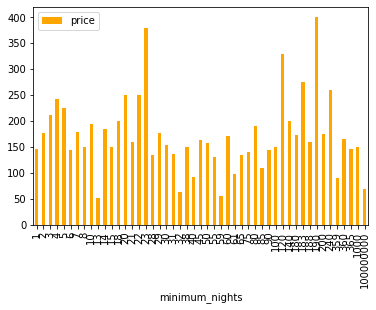

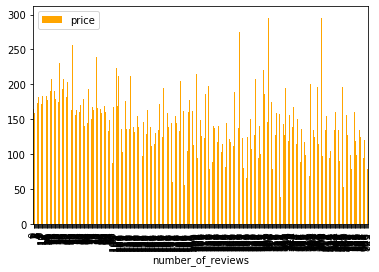

In [22]:
for column in df.columns:
    if column not in ('price_bin', 'price'):
        if column != 'room_type': 
            df[['price', column]].groupby(column).mean().reset_index().plot(x=column, y='price', kind='bar', color='orange')
            plt.show()
            

In [ ]:
#check number of rows and columns in dataset
df.shape

### KNN based on 14 bins

In [23]:
#this is your X
data2 = df2.drop(["price", "price_bin"], axis=1)
feature_names = data2.columns
data2.head()

,zipcode,room_type,accommodates,bedrooms,bathrooms,beds,minimum_nights,number_of_reviews
0,94117,Entire home/apt,3,1.0,1.0,2.0,1,240
1,94110,Entire home/apt,5,2.0,1.0,3.0,30,111
2,94117,Private room,2,1.0,4.0,1.0,32,19
3,94117,Private room,2,1.0,4.0,1.0,32,8
4,94110,Private room,3,1.0,1.0,1.0,1,736


In [25]:
#this is your y.  Convert to strings, even though it's already an array of strings, otherwise model will choke.
target = df2["price_bin"].map(lambda x:str(x))

df2.groupby("price_bin").count().index
print(target.unique())

['bin 144-180' 'bin 216-252' 'bin 36-72' 'bin 108-144' 'bin 72-108'
 'bin 432-468' 'bin 468-504' 'bin 180-216' 'bin 288-324' 'bin 324-360'
 'bin 0-36' 'bin 252-288' 'bin 360-396' 'bin 396-432']


In [26]:
data2.head()

,zipcode,room_type,accommodates,bedrooms,bathrooms,beds,minimum_nights,number_of_reviews
0,94117,Entire home/apt,3,1.0,1.0,2.0,1,240
1,94110,Entire home/apt,5,2.0,1.0,3.0,30,111
2,94117,Private room,2,1.0,4.0,1.0,32,19
3,94117,Private room,2,1.0,4.0,1.0,32,8
4,94110,Private room,3,1.0,1.0,1.0,1,736


In [27]:
#code for multi-column label encoder from stack overlow:
#https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()

        for col in self.columns:
            output[col] = LabelEncoder().fit_transform(output[col])

        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


In [29]:
#LabelEncode room_type and zipcode.  No need to one-hot encode

data2=MultiColumnLabelEncoder(columns = ['room_type', 'zipcode']).fit_transform(data2)
data2.head()

,zipcode,room_type,accommodates,bedrooms,bathrooms,beds,minimum_nights,number_of_reviews
0,14,0,3,1.0,1.0,2.0,1,240
1,8,0,5,2.0,1.0,3.0,30,111
2,14,1,2,1.0,4.0,1.0,32,19
3,14,1,2,1.0,4.0,1.0,32,8
4,8,1,3,1.0,1.0,1.0,1,736


In [30]:
data2.groupby(['room_type', 'zipcode' ]).count()

accommodates  bedrooms  bathrooms  beds  minimum_nights  \
room_type zipcode                                                            
0         0                  15        15         15    15              15   
          1                 224       224        224   224             224   
          2                 288       288        288   288             288   
          3                   5         5          5     5               5   
          4                 131       131        131   131             131   
...                         ...       ...        ...   ...             ...   
2         17                  5         5          5     5               5   
          19                  2         2          2     2               2   
          23                  1         1          1     1               1   
          24                 38        38         38    38              38   
          26                  4         4          4     4               4   

                   number_of_reviews  
room_type zipcode                     
0         0                       15  
          1                      224  
          2                      288  
          3                        5  
          4                      131  
...                              ...  
2         17                       5  
          19                       2  
          23                       1  
          24                      38  
          26                       4  

[73 rows x 6 columns]

In [31]:
#Use price for the y values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data2, target, random_state=42, test_size = .2)
 
y_train.dtypes

dtype('O')

In [32]:
#choose label encoder or one hot encode
#bins are already labels
2
#try each by themselves

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

len(y_test_categorical[0])
y_test_categorical[0]
len(y_train_categorical[0])

14

In [33]:
# Scale your data

from sklearn.preprocessing import MinMaxScaler


X_minmax = MinMaxScaler().fit(X_train)

X_train_scaled_ = X_minmax.transform(X_train)
X_test_scaled_= X_minmax.transform(X_test)

X_train_scaled_
#X_train_scaled.shape

array([[2.30769231e-01, 5.00000000e-01, 6.66666667e-02, ...,
        7.14285714e-02, 1.00000001e-08, 6.09013398e-03],
       [7.69230769e-02, 5.00000000e-01, 0.00000000e+00, ...,
        7.14285714e-02, 9.00000009e-08, 2.24116931e-01],
       [5.00000000e-01, 5.00000000e-01, 6.66666667e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.09622412e-02],
       ...,
       [2.69230769e-01, 0.00000000e+00, 2.00000000e-01, ...,
        1.42857143e-01, 2.90000003e-07, 0.00000000e+00],
       [5.38461538e-01, 0.00000000e+00, 6.66666667e-02, ...,
        7.14285714e-02, 2.90000003e-07, 1.51035323e-01],
       [4.23076923e-01, 0.00000000e+00, 2.00000000e-01, ...,
        1.42857143e-01, 2.90000003e-07, 0.00000000e+00]])

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_scaled_, y_train)

/Users/igorpyanin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
rf.feature_importances_

array([0.26939903, 0.05287182, 0.08860711, 0.04793555, 0.06913261,
       0.06780733, 0.04812424, 0.35612231])

In [36]:
data2.columns

Index(['zipcode', 'room_type', 'accommodates', 'bedrooms', 'bathrooms', 'beds',
       'minimum_nights', 'number_of_reviews'],
      dtype='object')

#### Scale data using random forest feature importances

In [37]:
rf_feature_importances = [0.26654518, 0.05109481, 0.08917569, 0.05407983, 0.06835171,
       0.06496296, 0.05581106, 0.34997875]

In [38]:
X_train_scaled = X_train_scaled_ * rf_feature_importances
X_test_scaled= X_test_scaled_ * rf_feature_importances

In [39]:
#get number of feature columns.  This will be the input dimension for the model.
X_train_scaled.shape
#X_train_scaled.shape[1]

(6004, 8)

#### Compare 'manhattan' and 'euclidean' metric 

In [40]:

from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 13, metric ='manhattan')
# Fit the classifier to the data
knn.fit(X_train_scaled,y_train)

#check accuracy of our model on the test data
knn.score(X_test_scaled, y_test)

0.3431045969353764

In [41]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 13, metric ='euclidean')
# Fit the classifier to the data
knn.fit(X_train_scaled,y_train)

#check accuracy of our model on the test data
knn.score(X_test_scaled, y_test)

0.3451032644903398

In [42]:
#show first 5 model predictions on the test data
knn.predict(X_test_scaled)[0:5]

array(['bin 108-144', 'bin 108-144', 'bin 36-72', 'bin 72-108',
       'bin 180-216'], dtype=object)

#### Choose best k value

k: 1, Train/Test Score: 0.890/0.321
k: 3, Train/Test Score: 0.562/0.329
k: 5, Train/Test Score: 0.509/0.332
k: 7, Train/Test Score: 0.482/0.331
k: 9, Train/Test Score: 0.460/0.332
k: 11, Train/Test Score: 0.447/0.344
k: 13, Train/Test Score: 0.435/0.345
k: 15, Train/Test Score: 0.429/0.342
k: 17, Train/Test Score: 0.417/0.346
k: 19, Train/Test Score: 0.413/0.334
k: 21, Train/Test Score: 0.410/0.334
k: 23, Train/Test Score: 0.401/0.329
k: 25, Train/Test Score: 0.396/0.338
k: 27, Train/Test Score: 0.390/0.334
k: 29, Train/Test Score: 0.380/0.318


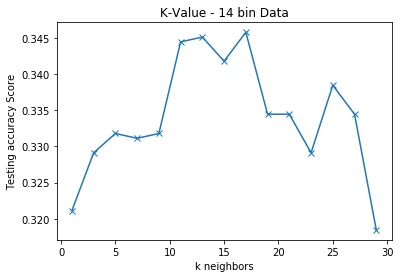

In [114]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
#plt.plot(range(1, 30, 2), train_scores, marker='o')
plt.plot(range(1, 30, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.title("K-Value - 14 bin Data")
plt.savefig("data_cleaning/Graphs/k_value_14-bin.png")
plt.show()

### Grid seach doesn't work because we don't use scaling for data2

In [107]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25, 2).tolist(), 'metric': ['euclidean', 'manhattan']}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [108]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'metric': 'euclidean', 'n_neighbors': 11}

In [109]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.33677548301132576

In [111]:
# Note that k: 13 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=17, metric='euclidean')
knn.fit(X_train_scaled, y_train)
print('k=17 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=17 Test Acc: 0.346


In [104]:
import joblib

filename = "modelKNN14.sav"

joblib.dump(rf, filename)

['modelKNN14.sav']